In [111]:
import tensorflow as tf
import tqdm
from GPT_2 import GPTModel
from GPT_2 import Utils 
import torch
import tiktoken
import numpy as np
from torch.utils.data import Dataset
import pandas as pd
from gpt_download3 import download_and_load_gpt2

## Downloading Weights

In [112]:
settings , params = download_and_load_gpt2(model_size="124M",models_dir="gpt2");

c:\Users\Smile\anaconda3\envs\tensorflow\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\checkpoint


c:\Users\Smile\anaconda3\envs\tensorflow\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\encoder.json


c:\Users\Smile\anaconda3\envs\tensorflow\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\hparams.json


c:\Users\Smile\anaconda3\envs\tensorflow\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001


c:\Users\Smile\anaconda3\envs\tensorflow\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\model.ckpt.index


c:\Users\Smile\anaconda3\envs\tensorflow\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\model.ckpt.meta


c:\Users\Smile\anaconda3\envs\tensorflow\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\vocab.bpe


In [113]:
print("Settings: ",settings)
print("Parameters Directory Keys: ",params.keys())

Settings:  {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameters Directory Keys:  dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [114]:
gt = Utils()

## Selecting Device

In [115]:
device = "cpu"

## GPT-2 124 Million Parameter

In [116]:
GPT_CONFIG_124M = {
    "vocab_size" : 50257,
    "context_length": 1024,
    "emb_dim" : 768,
    "n_heads" : 12,
    "drop_rate" : 0.1,
    "qkv_bias" : True,
    'n_layers' :12
}

In [117]:
gpt = GPTModel(GPT_CONFIG_124M)
gpt.eval();

In [118]:
tokenizer = tiktoken.get_encoding("gpt2")

## Loading Weights

In [119]:
gt.load_weights_into_gpt(gpt, params)
gpt.to(device=device);

In [120]:
prompt = "hello how are you"

idx = tokenizer.encode(prompt)

In [121]:
class Restaurant_Reviews_Dataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Review"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Liked"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [122]:
val_dataset = Restaurant_Reviews_Dataset(
    csv_file=r"..\Dataset\validation_data.csv",
    max_length=None,
    tokenizer=tokenizer
)
test_dataset = Restaurant_Reviews_Dataset(
    csv_file=r"..\Dataset\test_data.csv",
    max_length=None,
    tokenizer=tokenizer
)
train_dataset = Restaurant_Reviews_Dataset(
    csv_file=r"..\Dataset\train_data.csv",
    max_length=None,
    tokenizer=tokenizer
)

In [123]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [124]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [125]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [126]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [127]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [128]:
for param in gpt.parameters():
    param.requires_grad = False

In [129]:
for param in gpt.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in gpt.final_norm.parameters():
    param.requires_grad = True

In [130]:
def calc_loss_loader(self,data_loader, model, device, num_batches=None):
        total_loss = 0.
        if len(data_loader) == 0:
            return float("nan")
        elif num_batches is None:
            num_batches = len(data_loader)
        else:
            # Reduce the number of batches to match the total number of batches in the data loader
            # if num_batches exceeds the number of batches in the data loader
            num_batches = min(num_batches, len(data_loader))
        for i, (input_batch, target_batch) in enumerate(data_loader):
            if i < num_batches:
                loss = self.calc_loss_batch(input_batch, target_batch, model, device)
                total_loss += loss.item()
            else:
                break
        return total_loss / num_batches

In [131]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
        total_loss = 0.
        if len(data_loader) == 0:
            return float("nan")
        elif num_batches is None:
            num_batches = len(data_loader)
        else:
            # Reduce the number of batches to match the total number of batches in the data loader
            # if num_batches exceeds the number of batches in the data loader
            num_batches = min(num_batches, len(data_loader))
        for i, (input_batch, target_batch) in enumerate(data_loader):
            if i < num_batches:
                loss = calc_loss_batch(input_batch, target_batch, model, device)
                total_loss += loss.item()
            else:
                break
        return total_loss / num_batches

In [88]:
with torch.no_grad(): 
    train_loss = calc_loss_loader(train_loader, gpt, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, gpt, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, gpt, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 8.324
Validation loss: 10.545
Test loss: 11.121


In [132]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [96]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(gpt.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 6
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    gpt, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=7,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.857, Val loss 6.873
Ep 1 (Step 000050): Train loss 0.887, Val loss 2.119
Ep 1 (Step 000100): Train loss 0.824, Val loss 1.076
Training accuracy: 57.14% | Validation accuracy: 8.00%
Ep 2 (Step 000150): Train loss 0.783, Val loss 1.698
Ep 2 (Step 000200): Train loss 0.745, Val loss 0.935
Training accuracy: 44.64% | Validation accuracy: 12.00%
Ep 3 (Step 000250): Train loss 0.677, Val loss 0.912
Ep 3 (Step 000300): Train loss 0.676, Val loss 0.859
Training accuracy: 69.64% | Validation accuracy: 20.00%
Ep 4 (Step 000350): Train loss 0.624, Val loss 0.869
Ep 4 (Step 000400): Train loss 0.618, Val loss 0.807
Training accuracy: 76.79% | Validation accuracy: 64.00%
Ep 5 (Step 000450): Train loss 0.550, Val loss 0.653
Ep 5 (Step 000500): Train loss 0.483, Val loss 0.586
Ep 5 (Step 000550): Train loss 0.464, Val loss 0.510
Training accuracy: 78.57% | Validation accuracy: 86.00%
Ep 6 (Step 000600): Train loss 0.305, Val loss 0.417
Ep 6 (Step 000650): Train loss 0

In [97]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

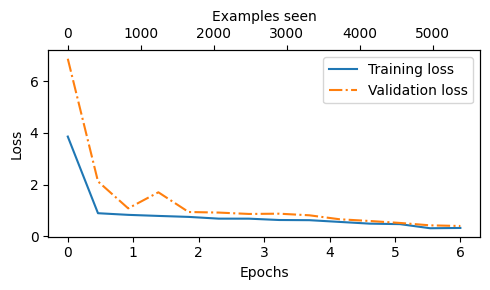

In [98]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

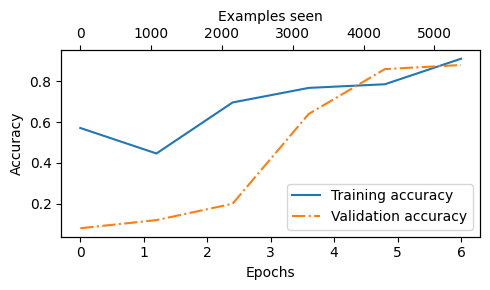

In [99]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [100]:
train_accuracy = calc_accuracy_loader(train_loader, gpt, device)
val_accuracy = calc_accuracy_loader(val_loader, gpt, device)
test_accuracy = calc_accuracy_loader(test_loader, gpt, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 84.71%
Validation accuracy: 88.00%
Test accuracy: 92.00%


In [101]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    # Note: In the book, this was originally written as pos_emb.weight.shape[1] by mistake
    # It didn't break the code but would have caused unnecessary truncation (to 768 instead of 1024)

    # Truncate sequences if they too long
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return "Positive" if predicted_label == 1 else "Negative"

In [102]:
text_1 = (
    "Food was  Amazing and Pasta was good"
)

print(classify_review(
    text_1, gpt, tokenizer, device, max_length=train_dataset.max_length
))

Positive


In [103]:
text_2 = (
    "Food was poor and very Bad. Pasta was very Bad."
)

print(classify_review(
    text_2, gpt, tokenizer, device, max_length=train_dataset.max_length
))

Negative


In [104]:
text_3 = (
    "My first visit to Hiro was a delight!"
)

print(classify_review(
    text_3, gpt, tokenizer, device, max_length=train_dataset.max_length
))

Positive


In [105]:
text_4 = (
    "I vomited in the bathroom mid lunch."
)

print(classify_review(
    text_4, gpt, tokenizer, device, max_length=train_dataset.max_length
))

Negative


In [106]:
Positive = ["The food was absolutely delicious.",
"I had an amazing experience at the resort.",
"The staff was incredibly helpful and friendly.",
"This product exceeded my expectations.",
"The scenery was breathtaking and serene."]

In [107]:
Negative = ["The food was terrible and tasteless.",
"I had a horrible experience with the customer service.",
"Very worst experience . Bad quality of food. ",
"This was a complete waste of time and money.",
"The noise levels were unbearable."]

In [108]:
for i  in Positive:
    
    text = (i)

    print(classify_review(
        text, gpt, tokenizer, device, max_length=train_dataset.max_length
    ))

Positive
Positive
Positive
Positive
Positive


In [109]:
for i  in Negative:
    
    text = (i)

    print(classify_review(
        text, gpt, tokenizer, device, max_length=train_dataset.max_length
    ))

Negative
Negative
Negative
Negative
Negative


In [110]:
optimizer = torch.optim.Adam(gpt.parameters(),lr=0.0004,weight_decay=0.1)

torch.save({

       "model_state_dict":gpt.state_dict(),
       "optimizer_state_dict" : optimizer.state_dict(),
    },
    r"model_and_optimizer.pth"
)

In [ ]:
# checkpoint = torch.load("model_and_optimizer.pth")
# gpt = GPTModel(GPT_CONFIG_124M)
# gpt.load_state_dict(checkpoint['model_state_dict'])
# optimizer = torch.optim.Adam(gpt.parameters(),lr=0.0004,weight_decay=0.1)
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# gpt.train();